#### Imports

In [1]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

## Filtering and Combining Desired Reviews

In [2]:
# Load the combined reviews data from the saved file
combined_reviews_df = pd.read_csv('processed_data/combined_reviews.csv', encoding='utf-8', engine='python')

# Filter the reviews with 4 and 5 stars
frequent_items_reviews = combined_reviews_df[combined_reviews_df['rating'].isin([4, 5])]

# Load the positive reviews from the sentiment analysis on the 3-star reviews
positive_reviews_df = pd.read_csv('processed_data/3_star_positive_reviews.csv', encoding='utf-8', engine='python')

# Combine the filtered 4 and 5-star reviews with the 3-star positive reviews
frequent_items_reviews = pd.concat([frequent_items_reviews, positive_reviews_df], ignore_index=True)

print(f"Total reviews to be used in frequent items: {len(frequent_items_reviews)}")

Total reviews to be used in frequent items: 693706


## Frequent Items

In [3]:
# Step 1: Aggregate reviews by user
user_review_counts = frequent_items_reviews.groupby('author_id')['product_id'].nunique()

# Step 2: Define thresholds for grouping
thresholds = list(range(2, 11)) + [20, 30] + list(range(40, user_review_counts.max() + 10, 10))

# Step 3: Count users per group
users_per_group = []

for t in thresholds:
    count = (user_review_counts >= t).sum()
    users_per_group.append(count)

# Step 4: Display results
print("Users per group:")
for t, count in zip(thresholds, users_per_group):
    print(f"{t}+ reviews: {count} users")

Users per group:
2+ reviews: 117420 users
3+ reviews: 55361 users
4+ reviews: 30695 users
5+ reviews: 18753 users
6+ reviews: 12557 users
7+ reviews: 9009 users
8+ reviews: 6901 users
9+ reviews: 5534 users
10+ reviews: 4613 users
20+ reviews: 1574 users
30+ reviews: 825 users
40+ reviews: 458 users
50+ reviews: 256 users
60+ reviews: 138 users
70+ reviews: 77 users
80+ reviews: 34 users
90+ reviews: 13 users
100+ reviews: 7 users
110+ reviews: 6 users
120+ reviews: 4 users
130+ reviews: 2 users
140+ reviews: 1 users
150+ reviews: 1 users
160+ reviews: 1 users
170+ reviews: 1 users
180+ reviews: 1 users
190+ reviews: 1 users
200+ reviews: 1 users
210+ reviews: 0 users


/Users/raquel/opt/anaconda3/envs/tutorial/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/raquel/opt/anaconda3/envs/tutorial/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/raquel/opt/anaconda3/envs/tutorial/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


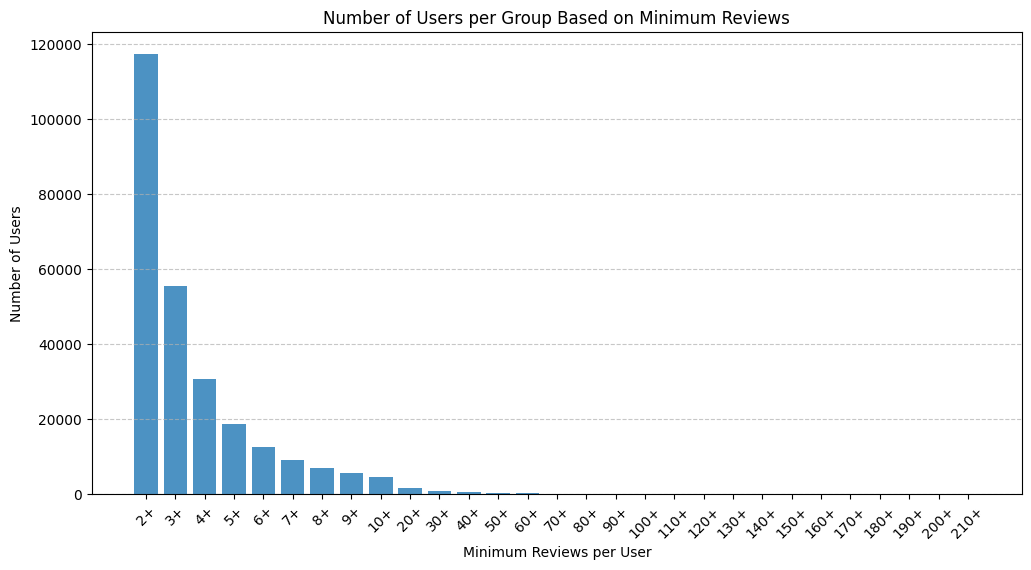

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar([str(t) + "+" for t in thresholds], users_per_group, alpha=0.8)
plt.title("Number of Users per Group Based on Minimum Reviews")
plt.xlabel("Minimum Reviews per User")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/Users/raquel/opt/anaconda3/envs/tutorial/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/Users/raquel/opt/anaconda3/envs/tutorial/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/Users/raquel/opt/anaconda3/envs/tutorial/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/Users/raquel/opt/anaconda3/envs/tutorial/lib/python3.1

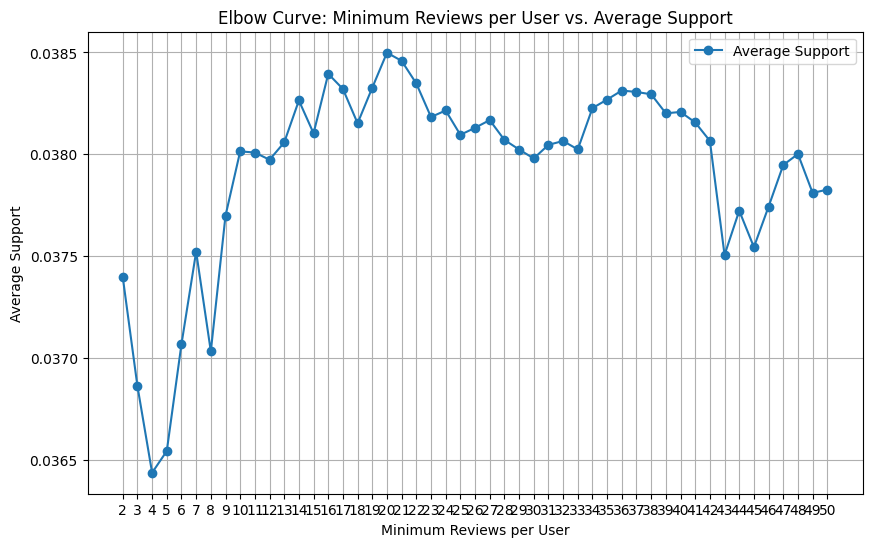

In [5]:
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

# Step 1: Aggregate reviews by user
user_review_counts = frequent_items_reviews.groupby('author_id')['product_id'].nunique()

# Step 2: Initialize thresholds and results
thresholds = range(2, min(51, user_review_counts.max() + 1))  # Limit thresholds to 2+ to 50+ reviews
avg_supports = []  # Average support for each threshold

for t in thresholds:
    # Filter users with at least `t` reviews
    filtered_users = user_review_counts[user_review_counts >= t].index
    filtered_data = frequent_items_reviews[frequent_items_reviews['author_id'].isin(filtered_users)]

    # Create a transaction dataset for apriori
    transaction_df = (
        filtered_data.groupby('author_id')['product_id']
        .apply(list)
        .explode()
        .reset_index(drop=True)
        .str.join('|')  # Join product IDs to form transactions
        .str.get_dummies('|')  # One-hot encode the product transactions
    )

    # Apply apriori algorithm
    frequent_itemsets = apriori(transaction_df, min_support=0.01, use_colnames=True)

    # Calculate the number of frequent itemsets
    num_itemsets = len(frequent_itemsets)

    # Call association_rules with num_itemsets (required for older versions of mlxtend)
    rules = association_rules(frequent_itemsets, num_itemsets=num_itemsets, metric='support', min_threshold=0.01)

    # Calculate the average support of the rules
    avg_support = rules['support'].mean() if not rules.empty else 0
    avg_supports.append(avg_support)

# Step 3: Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, avg_supports, marker='o', label='Average Support')
plt.title('Elbow Curve: Minimum Reviews per User vs. Average Support')
plt.xlabel('Minimum Reviews per User')
plt.ylabel('Average Support')
plt.grid(True)
plt.xticks(thresholds)
plt.legend()
plt.show()

In [6]:
for t, s in zip(thresholds, avg_supports):
    print(f"Threshold: {t}+ reviews | Avg Support: {s:.4f}")

Threshold: 2+ reviews | Avg Support: 0.0374
Threshold: 3+ reviews | Avg Support: 0.0369
Threshold: 4+ reviews | Avg Support: 0.0364
Threshold: 5+ reviews | Avg Support: 0.0365
Threshold: 6+ reviews | Avg Support: 0.0371
Threshold: 7+ reviews | Avg Support: 0.0375
Threshold: 8+ reviews | Avg Support: 0.0370
Threshold: 9+ reviews | Avg Support: 0.0377
Threshold: 10+ reviews | Avg Support: 0.0380
Threshold: 11+ reviews | Avg Support: 0.0380
Threshold: 12+ reviews | Avg Support: 0.0380
Threshold: 13+ reviews | Avg Support: 0.0381
Threshold: 14+ reviews | Avg Support: 0.0383
Threshold: 15+ reviews | Avg Support: 0.0381
Threshold: 16+ reviews | Avg Support: 0.0384
Threshold: 17+ reviews | Avg Support: 0.0383
Threshold: 18+ reviews | Avg Support: 0.0382
Threshold: 19+ reviews | Avg Support: 0.0383
Threshold: 20+ reviews | Avg Support: 0.0385
Threshold: 21+ reviews | Avg Support: 0.0385
Threshold: 22+ reviews | Avg Support: 0.0383
Threshold: 23+ reviews | Avg Support: 0.0382
Threshold: 24+ rev

In [7]:
# Selecting users with at least 10 reviews
filtered_df = frequent_items_reviews.groupby('author_id').filter(lambda x: x['product_id'].nunique() > 9)

# Display the filtered DataFrame
print(f"Number of rows in the filtered dataframe: {len(filtered_df)}")
print(f"Number of unique authors in the filtered dataframe: {len(set(filtered_df['author_id']))}")
#set(filtered_df['author_id'])

Number of rows in the filtered dataframe: 95902
Number of unique authors in the filtered dataframe: 4613


In [8]:
# Combining all the products reviewed for each person in the dataset
selected_columns = filtered_df[['author_id', 'product_id']]

# Convert product_id to string before applying 'join'
combined_reviews = selected_columns.groupby('author_id')['product_id'].apply(lambda x: ' '.join(x.astype(str))).reset_index()

print(combined_reviews)

            author_id                                         product_id
0          1000235057  P420652 P421275 P297524 P456412 P232903 P37584...
1         10003868106  P420652 P480612 P375849 P375853 P472468 P37585...
2          1001087549  P309308 P423688 P270594 P433520 P232915 P45621...
3         10015807972  P420652 P427419 P454380 P480612 P427406 P42741...
4         10021044780  P309308 P442840 P466123 P500633 P418346 P47641...
...               ...                                                ...
4608        998162812  P269122 P429952 P471237 P443833 P422022 P37970...
4609        998179876  P309308 P429952 P270594 P442840 P466123 P44779...
4610        998853649  P456398 P461159 P461933 P456213 P429242 P41561...
4611       9990263118  P430337 P427406 P431180 P440307 P410400 P45567...
4612  orderGen1698648  P443833 P428095 P455926 P502656 P446423 P45536...

[4613 rows x 2 columns]


In [ ]:
def adaptive_support(df):
    # Adjust column names to match your DataFrame
    item_column = 'product_id'  # Replace with the correct column name for items
    transaction_column = 'author_id'  # Replace with the correct column name for transactions
    criteria_column = 'rating'  # Replace with the correct column name for criteria value

    # Extract unique items and their criteria values
    unique_items = df[item_column].unique()
    num_transactions = df[transaction_column].nunique()
    num_items = len(unique_items)

    # Initialize required dictionaries and variables
    support = {}  # S(d): support value for each item
    utility = {}  # U(d): utility value for each item
    criteria_values = df.groupby(item_column)[criteria_column].first()  # Assume criteria_value exists
    total_utility = 0  # Sum of utilities

    # Calculate support and utility for each item
    for item in unique_items:
        frequency = df[df[item_column] == item].shape[0]  # Count occurrences
        support[item] = frequency / num_transactions  # S(d) = n(d) / |D|
        utility[item] = support[item] * criteria_values[item]  # U(d) = S(d) * X(d)
        total_utility += utility[item]  # Sum = Sum + U(d)

    # Calculate average support and minimum threshold
    ave_sup = total_utility / num_items  # Avesup = Sum / |N|
    min_threshold = ave_sup / num_transactions  # Min_threshold = Avesup / |D|

    return ave_sup, min_threshold, support, utility

# Example usage
# combined_df should contain columns like 'product_id', 'author_id', and 'criteria_value'.
avesup, min_threshold, support, utility = adaptive_support(cleaned_df)
print(f"Average Support (Avesup): {avesup}")
print(f"Minimum Threshold (Min_threshold): {min_threshold}")
print("Support values (S):", support)
print("Utility values (U):", utility)

In [9]:
# Convert the 'reviews' into a list of transactions
transactions = combined_reviews['product_id'].str.split().tolist()

# Create a DataFrame for one-hot encoding
# Flatten all unique items (reviews) and create a unique item list
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# Apply the Apriori algorithm
frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

# Focus on frequent itemsets containing only a single product (not pairs or larger sets)
frequent_pairs = frequent_itemsets[frequent_itemsets['itemsets'].apply(len) == 1]

# Generate association rules, with support as minimum of 3%
rules = association_rules(frequent_itemsets, metric="support", min_threshold=0.000000007, num_itemsets=len(frequent_itemsets))

print(frequent_pairs)

      support   itemsets
0    0.014307   (P12045)
1    0.016909   (P12336)
2    0.013007   (P12573)
3    0.020160  (P126301)
4    0.010405  (P203616)
..        ...        ...
490  0.012356  (P505711)
491  0.014307   (P54509)
492  0.033817    (P7880)
493  0.029265   (P94421)
494  0.011706    (P9940)

[495 rows x 2 columns]


In [15]:
# Filter rules to include only those where antecedents have a single item
rules_filtered = rules[rules['antecedents'].apply(len) == 1].copy()

rules_display = rules_filtered[["antecedents", "consequents", "support", "confidence", "lift"]].copy()

# Convert frozensets to readable strings
rules_display["antecedents"] = rules_display["antecedents"].apply(lambda x: ', '.join(list(x)))
rules_display["consequents"] = rules_display["consequents"].apply(lambda x: ', '.join(list(x)))

# Sorting by confidence
rules_display = rules_display.sort_values(by="support", ascending=False)
print(rules_display.to_string(index=False))

antecedents                                 consequents  support  confidence      lift
    P270594                                     P500633 0.148277    0.563427  1.991638
    P500633                                     P270594 0.148277    0.524138  1.991638
    P503936                                     P500633 0.127249    0.596545  2.108706
    P500633                                     P503936 0.127249    0.449808  2.108706
    P503936                                     P270594 0.122263    0.573171  2.177954
    P270594                                     P503936 0.122263    0.464580  2.177954
    P476414                                     P500633 0.113809    0.531377  1.878345
    P500633                                     P476414 0.113809    0.402299  1.878345
    P476414                                     P270594 0.110774    0.517206  1.965299
    P270594                                     P476414 0.110774    0.420923  1.965299
    P500777                                

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []


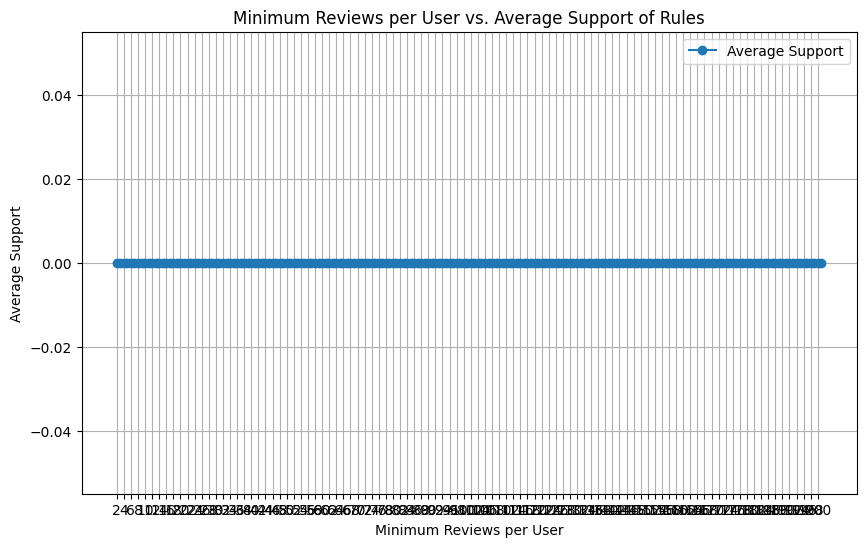

Threshold: 2+ reviews | Avg Support: 0.0000
Threshold: 3+ reviews | Avg Support: 0.0000
Threshold: 4+ reviews | Avg Support: 0.0000
Threshold: 5+ reviews | Avg Support: 0.0000
Threshold: 6+ reviews | Avg Support: 0.0000
Threshold: 7+ reviews | Avg Support: 0.0000
Threshold: 8+ reviews | Avg Support: 0.0000
Threshold: 9+ reviews | Avg Support: 0.0000
Threshold: 10+ reviews | Avg Support: 0.0000
Threshold: 11+ reviews | Avg Support: 0.0000
Threshold: 12+ reviews | Avg Support: 0.0000
Threshold: 13+ reviews | Avg Support: 0.0000
Threshold: 14+ reviews | Avg Support: 0.0000
Threshold: 15+ reviews | Avg Support: 0.0000
Threshold: 16+ reviews | Avg Support: 0.0000
Threshold: 17+ reviews | Avg Support: 0.0000
Threshold: 18+ reviews | Avg Support: 0.0000
Threshold: 19+ reviews | Avg Support: 0.0000
Threshold: 20+ reviews | Avg Support: 0.0000
Threshold: 21+ reviews | Avg Support: 0.0000
Threshold: 22+ reviews | Avg Support: 0.0000
Threshold: 23+ reviews | Avg Support: 0.0000
Threshold: 24+ rev

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Aggregate reviews by user
user_review_counts = frequent_items_reviews.groupby('author_id')['product_id'].nunique()

# Step 2: Define thresholds for minimum reviews per user
thresholds = range(2, user_review_counts.max() + 1)

# Step 3: Prepare to store results
avg_supports = []

for t in thresholds:
    # Filter users with at least `t` reviews
    filtered_users = user_review_counts[user_review_counts >= t].index
    filtered_data = frequent_items_reviews[frequent_items_reviews['author_id'].isin(filtered_users)]
    
    # Keep only the filtered users' rules
    filtered_rules = rules[rules['antecedent support'].apply(lambda x: x in filtered_users)]
    
    # Calculate average support
    avg_support = filtered_rules['support'].mean() if not filtered_rules.empty else 0
    avg_supports.append(avg_support)

print(filtered_rules)

# Step 4: Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, avg_supports, marker='o', label='Average Support')
plt.title('Minimum Reviews per User vs. Average Support of Rules')
plt.xlabel('Minimum Reviews per User')
plt.ylabel('Average Support')
plt.grid(True)
plt.xticks(thresholds[::2])  # Label every 2nd threshold for clarity
plt.legend()
plt.show()

# Print data for verification
for t, support in zip(thresholds, avg_supports):
    print(f"Threshold: {t}+ reviews | Avg Support: {support:.4f}")

In [12]:
# let's try to quantify this
unique_values = pd.concat([rules_display['antecedents'], rules_display['consequents']]).nunique()
unique_values

11203

## Testing

In [13]:
filtered_rules = rules_display[rules_display['antecedents'].apply(lambda x: 'P447596' in x)]
print(filtered_rules)

Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


In [14]:
filtered_rules = rules_display[rules_display['antecedents'].apply(lambda x: 'P500633' in x)]
print(filtered_rules)

       antecedents                         consequents   support  confidence  \
437        P500633                             P270594  0.148277    0.524138   
8101       P500633                             P503936  0.127249    0.449808   
5698       P500633                             P476414  0.113809    0.402299   
8047       P500633                             P500777  0.106005    0.374713   
6627       P500633                             P479841  0.105571    0.373180   
...            ...                                 ...       ...         ...   
112243     P500633           P442840, P423688, P482551  0.010189    0.036015   
173646     P500633  P503936, P500857, P270594, P476414  0.010189    0.036015   
173705     P500633  P501254, P270594, P503726, P476414  0.010189    0.036015   
188466     P500633  P471237, P479841, P501760, P476414  0.010189    0.036015   
165965     P500633  P479645, P270594, P469538, P476414  0.010189    0.036015   

            lift  
437     1.991638  
8